In [33]:
import os
import csv

def readCSVFile(filename):
    lines = []
    with open(filename) as csvfile:
        reader = csv.reader(csvfile)
        for line in reader:
            lines.append(line)

    # Remove the first line
    lines = lines[1:]

    return(lines)

my_csv_lines1 = readCSVFile('./mydata/driving_log1.csv')
my_csv_lines2 = readCSVFile('./mydata/driving_log2.csv')

my_csv_lines = my_csv_lines1 + my_csv_lines2

print("Number of lines read from the CSV files: " + str(len(my_csv_lines)))
print()

print("Example of line:")
line = my_csv_lines[0]
print(line)

Number of lines read from the CSV files: 10671

Example of line:
['/Users/nielsdrejer/Documents/Udacity/Self-Driving Car Engineer/Project 1.3/CarND-Behavioral-Cloning-P3/mydata/IMG/center_2018_03_11_19_12_20_552.jpg', '/Users/nielsdrejer/Documents/Udacity/Self-Driving Car Engineer/Project 1.3/CarND-Behavioral-Cloning-P3/mydata/IMG/left_2018_03_11_19_12_20_552.jpg', '/Users/nielsdrejer/Documents/Udacity/Self-Driving Car Engineer/Project 1.3/CarND-Behavioral-Cloning-P3/mydata/IMG/right_2018_03_11_19_12_20_552.jpg', '0', '0', '0', '2.509404E-06']


In [40]:
def makeListOfPathsAndMeasurements(my_input_lines, correction=0.2):

    measurements = []
    imagePaths = []
    
    # Extract center, left and right image paths as well as the associated measurement from each line
    for line in my_input_lines:
        center_image = line[0]
        left_image = line[1].strip()
        right_image = line[2].strip()
        steering_value = float(line[3])
    
        # Apply the correction parameter to create artificial measurements for the left and right images
        measurements.append(steering_value)
        measurements.append(steering_value + correction)
        measurements.append(steering_value - correction)
        
        imagePaths.append(center_image)
        imagePaths.append(left_image)
        imagePaths.append(right_image)
        
    return(list(zip(imagePaths, measurements)))

samples = makeListOfPathsAndMeasurements(my_csv_lines, 0.2)

print("Total number of pairs of image paths and steering angle: " + str(len(samples)))
print()
print("Image path for sample[0]: " + str(samples[0][0]))
print("Steering angle for sample[0]: " + str(samples[0][1]))

Total number of pairs of image paths and steering angle: 32013

Image path for sample[0]: /Users/nielsdrejer/Documents/Udacity/Self-Driving Car Engineer/Project 1.3/CarND-Behavioral-Cloning-P3/mydata/IMG/center_2018_03_11_19_12_20_552.jpg
Steering angle for sample[0]: 0.0


Image data shape = (160, 320, 3)


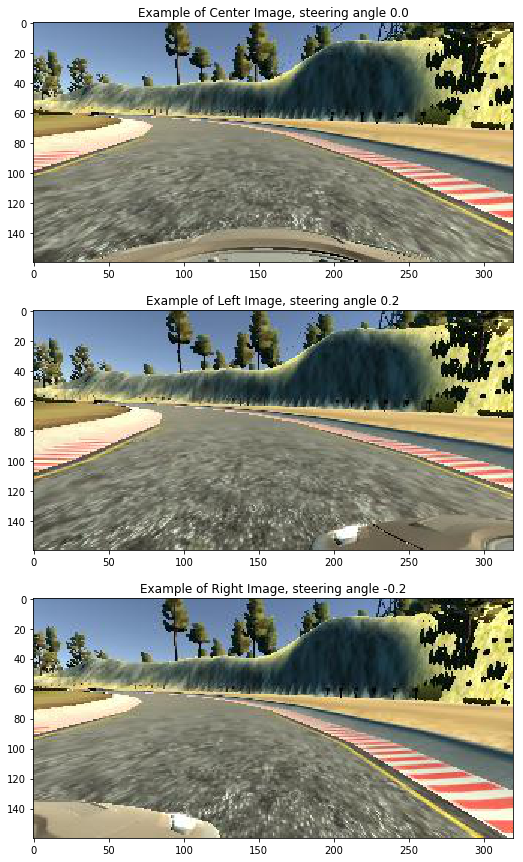

In [51]:
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

# Read the images. cv2.imread returns BGR format
image_c = cv2.imread(samples[0][0])
image_l = cv2.imread(samples[1][0])
image_r = cv2.imread(samples[2][0])

# Convert the images to RGB for proper display
b,g,r = cv2.split(image_c)
rgb_image_c = cv2.merge([r,g,b])

b,g,r = cv2.split(image_l)
rgb_image_l = cv2.merge([r,g,b])

b,g,r = cv2.split(image_r)
rgb_image_r = cv2.merge([r,g,b])

# Image dimensions
image_shape = image_c.shape
print("Image data shape =", image_shape)

# Display center, left and right images
fig = plt.figure(figsize=(15,15))
a = fig.add_subplot(3, 1, 1)
title = "Example of Center Image, steering angle " + str(samples[0][1])
a.set_title(title)
plt.imshow(rgb_image_c)
b = fig.add_subplot(3, 1, 2)
title = "Example of Left Image, steering angle " + str(samples[1][1])
b.set_title(title)
plt.imshow(rgb_image_l)
c = fig.add_subplot(3, 1, 3)
title = "Example of Right Image, steering angle " + str(samples[2][1])
c.set_title(title)
plt.imshow(rgb_image_r)

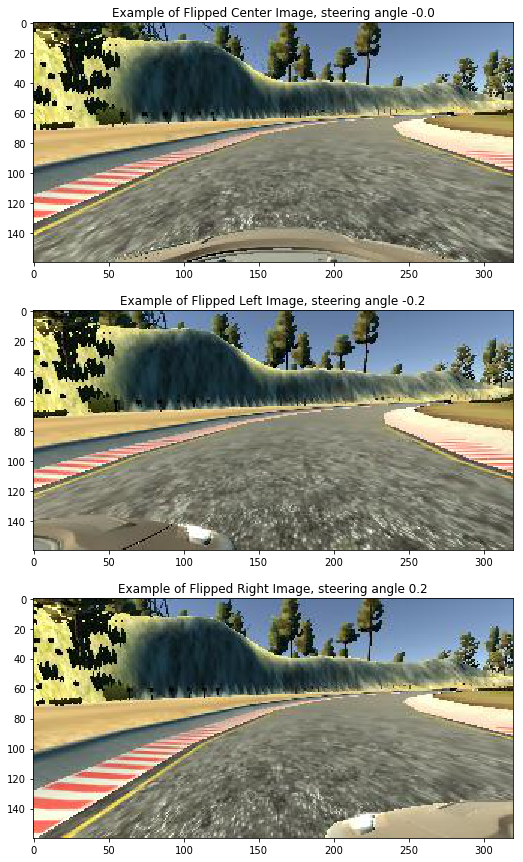

In [66]:
flipped_rgb_image_c = cv2.flip(rgb_image_c,1)
flipped_rgb_image_l = cv2.flip(rgb_image_l,1)
flipped_rgb_image_r = cv2.flip(rgb_image_r,1)

# Display flipped center, left and right images
fig = plt.figure(figsize=(15,15))
a = fig.add_subplot(3, 1, 1)
title = "Example of Flipped Center Image, steering angle " + str(-1.0*samples[0][1])
a.set_title(title)
plt.imshow(flipped_rgb_image_c)
b = fig.add_subplot(3, 1, 2)
title = "Example of Flipped Left Image, steering angle " + str(-1.0*samples[1][1])
b.set_title(title)
plt.imshow(flipped_rgb_image_l)
c = fig.add_subplot(3, 1, 3)
title = "Example of Flipped Right Image, steering angle " + str(-1.0*samples[2][1])
c.set_title(title)
plt.imshow(flipped_rgb_image_r)

32013
0.0


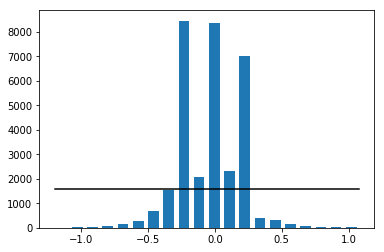

In [60]:
# Extract all the steering angle measurements
measurements = [samples[x][1] for x in range(len(samples))]

num_bins = 20
average_samples_per_bin = len(measurements)/num_bins

hist, bins = np.histogram(measurements, num_bins)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)
plt.plot((np.min(measurements), np.max(measurements)), (average_samples_per_bin,average_samples_per_bin), 'k-')

print(len(measurements))
print(measurements[15000])

In [3]:
from sklearn.model_selection import train_test_split

train_samples, validation_samples = train_test_split(samples, test_size=0.2)

import cv2
import numpy as np
import sklearn

def generator(samples, batch_size=32):
    # Note this function will generate batches which are twice the size of the batch_size parameter
    # because it also flips each image.
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        sklearn.utils.shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            angles = []
            for batch_sample in batch_samples:
                name = batch_sample[0]
                image = cv2.imread(name)

                # Convert from BGR to RGB format. cv2.imread returns BGR, but the simulator produces RGB.      
                b,g,r = cv2.split(image)
                rgb_image = cv2.merge([r,g,b])

                angle = float(batch_sample[1])
                images.append(rgb_image)
                angles.append(angle)
                
                # Flip image and produce the second image
                images.append(cv2.flip(rgb_image,1))
                angles.append(angle * -1.0)

            X_train = np.array(images)
            y_train = np.array(angles)
            yield sklearn.utils.shuffle(X_train, y_train)

# compile and train the model using the generator function
train_generator = generator(train_samples, batch_size=32)
validation_generator = generator(validation_samples, batch_size=32)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Lambda, Cropping2D
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D

def nVidiaModel():
    model = Sequential()
    # Preprocessing
    model.add(Lambda(lambda x: (x / 255.0) - 0.5, input_shape=(160,320,3)))
    model.add(Cropping2D(cropping=((50,20), (0,0))))
    
    model.add(Convolution2D(24,5,5, subsample=(2,2), activation='relu'))
    model.add(Convolution2D(36,5,5, subsample=(2,2), activation='relu'))
    model.add(Convolution2D(48,5,5, subsample=(2,2), activation='relu'))
    model.add(Convolution2D(64,3,3, activation='relu'))
    model.add(Convolution2D(64,3,3, activation='relu'))
    model.add(Flatten())
    model.add(Dense(100))
    model.add(Dense(50))
    model.add(Dense(10))
    model.add(Dense(1)) 
    
    return model

In [ ]:
model = nVidiaModel()
model.compile(loss='mse', optimizer='adam')
history = model.fit_generator(train_generator, samples_per_epoch=(2*len(train_samples)),
                              validation_data=validation_generator, nb_val_samples=(2*len(validation_samples)),
                              nb_epoch=3, verbose=1)

#model.save('model.h5')

In [64]:
from keras.models import load_model
load_model('model.h5').summary()

Using TensorFlow backend.
/Users/nielsdrejer/anaconda/envs/carnd-term1/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 160, 320, 3)   0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
cropping2d_1 (Cropping2D)        (None, 90, 320, 3)    0           lambda_1[0][0]                   
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 43, 158, 24)   1824        cropping2d_1[0][0]               
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 20, 77, 36)    21636       convolution2d_1[0][0]            
___________________________________________________________________________________________

Number of lines read from my driving_log.csv files: 10671
Number of training samples: 25610
Number of validation samples: 6403
Epoch 1/3
51220/51220 [==============================] - 1399s - loss: 0.0271 - val_loss: 0.0217
Epoch 2/3
51220/51220 [==============================] - 1413s - loss: 0.0209 - val_loss: 0.0182
Epoch 3/3
51220/51220 [==============================] - 1394s - loss: 0.0178 - val_loss: 0.0166


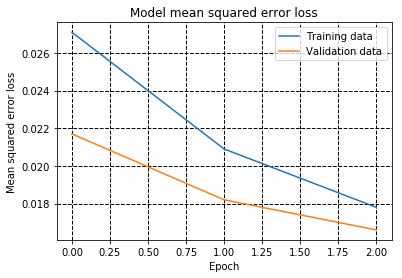

In [62]:
loss = [0.0271, 0.0209, 0.0178]
val_loss = [0.0217, 0.0182, 0.0166]

plt.plot(loss)
plt.plot(val_loss)
plt.title('Model mean squared error loss')
plt.ylabel('Mean squared error loss')
plt.xlabel('Epoch')
plt.legend(['Training data', 'Validation data'], loc='upper right')
plt.grid(color='black', linestyle='--', linewidth=1)
plt.show()